In [50]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [52]:
class BraessNetwork(object):
    """Stores the cost for all links. Handles calculating the cost of a path given action
       of every car.
    """
    def __init__(self):
        self.__links = {
            "AB": lambda f: 1 + f, #(f/100),
            "AC": lambda _: 2,
            "BD": lambda _: 2,
            "CD": lambda f: 1 + f, #(f/100),
            "BC": lambda _: 0.25
        } # Dictionary of links and their congestion functions
        self.__paths = {
            "ABD": ("AB", "BD"),
            "ACD": ("AC", "CD"),
            "ABCD": ("AB", "BC", "CD")
        } # Dictionaries of paths to links
        return 
    
    def paths(self):
        """Gives a list of all possible paths in the network to the environment. 
           The environment could then assign an action number to each path. 
        """
        return ("ABD", "ACD", "ABCD")
    
    def calculate_ttime(self, flows):
        """Given a dictionary of paths and flows, this function returns a dictionary of 
           paths and travel time (secs), a.k.a ttime.
           
           Returns: 
               travel_times (dictionary): A dictionary of paths to their travel times
        """
        congestion = {}
        for path in flows:
            links = self.__paths[path]
            for link in links:
                if link not in congestion:
                    congestion[link] = 0
                congestion[link] += flows[path]
        
        t_time = {}
        for path in flows:
            total_time = 0
            # Calculate travel time of path by adding the congestion time of every 
            # link in that path
            links = self.__paths[path]
            for link in links:
                t_time_func = self.__links[link]
                total_time += t_time_func(congestion[link])
            t_time[path] = total_time
        
        return t_time
    
    def calculate_ttime_lambda(self, flows, Lambda):
        """Given a dictionary of paths and flows, this function returns a dictionary of 
           paths and travel time, considering the social factor lambda (secs).
           
           Returns: 
               travel_times (dictionary): A dictionary of paths to their travel times,
               considering the social factor lambda
        """
        congestion = {}
        for path in flows:
            links = self.__paths[path]
            for link in links:
                if link not in congestion:
                    congestion[link] = 0
                congestion[link] += flows[path]
        
        t_time_lambda = {}
        for path in flows:
            total_time = 0
            # Calculate travel time of path by adding the congestion time of every 
            # link in that path, and plus the social factor
            links = self.__paths[path]
            for link in links:
                if link == "AB" or link == "CD":
                    total_time += Lambda * congestion[link]
                t_time_func = self.__links[link]
                total_time += t_time_func(congestion[link])
            t_time_lambda[path] = total_time
        
        return t_time_lambda

In [94]:
Network = BraessNetwork()
T = 10000
rho = 5
flow = [1/3]*3
flows_Hedge = dict(zip(Network.paths(), flow))
ttravel_Hedge = np.zeros((T,3))
f_Hedge = np.zeros((T+1,3))
f_Hedge[0,:] = flow

# Hedge
for i in range(T):
    flow = np.array(flow)
    learning_rate = 1/np.sqrt(i+1)
    travel_time = np.array(list((Network.calculate_ttime(flows_Hedge).values())))
    ttravel_Hedge[i,:] = travel_time
    flow *= np.exp(-learning_rate*travel_time/rho)  # hedge update
    flow /= sum(flow)
    f_Hedge[i+1,:] = flow
    flows_Hedge = dict(zip(Network.paths(),flow))
    

In [95]:
Network = BraessNetwork()
T = 10000
rho = 5
flow = [1/3]*3
flows_Replicator = dict(zip(Network.paths(),flow))
ttravel_Replicator = np.zeros((T,3))
f_Replicator = np.zeros((T+1,3))
f_Replicator[0,:] = flow

# Replicator
for i in range(T):
    learning_rate = 1/np.sqrt(i+1)
    travel_time = np.array(list((Network.calculate_ttime(flows_Hedge).values())))
    ttravel_Replicator[i,:] = travel_time
    mean = np.dot(flow, travel_time)
    flow *= (1 + learning_rate * (mean - travel_time)/rho)  # Replicator update
    flow /= sum(flow)
    f_Replicator[i+1,:] = flow
    flows_Replicator = dict(zip(Network.paths(),flow))


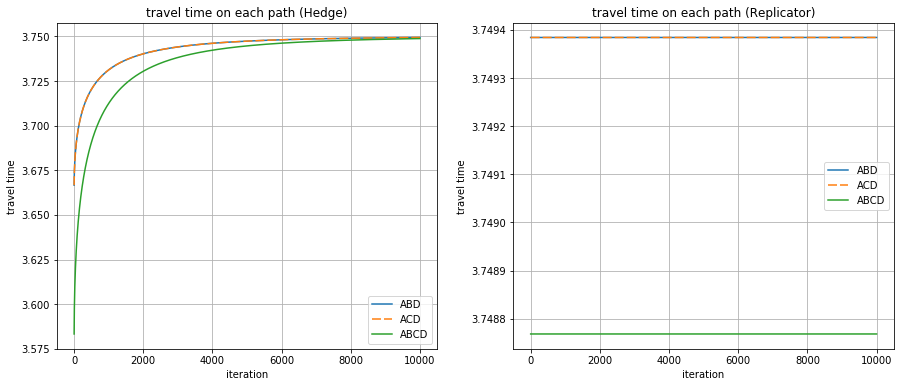

In [96]:
plt.figure(figsize=(15,6))
plt.subplot(121)
time = range(T)
plt.plot(time, ttravel_Hedge[:,0], label='ABD')
plt.plot(time, ttravel_Hedge[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Hedge[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Hedge)')
plt.grid()
plt.legend()

plt.subplot(122)

time = range(T)
plt.plot(time, ttravel_Replicator[:,0], label='ABD')
plt.plot(time, ttravel_Replicator[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Replicator[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Replicator)')
plt.grid()
plt.legend()
plt.show()

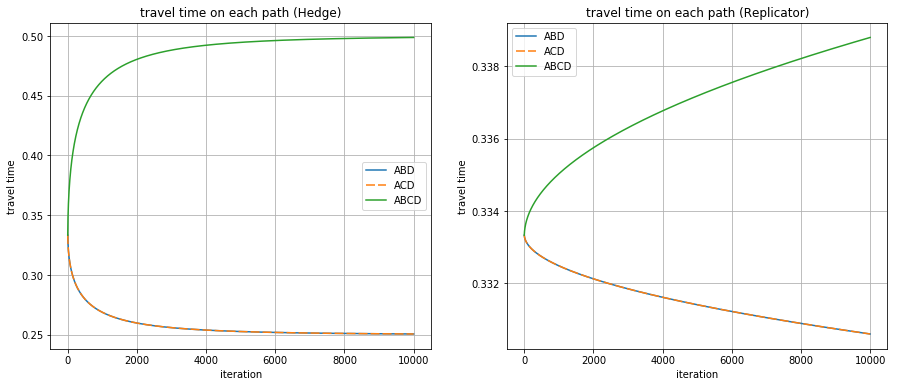

In [97]:
plt.figure(figsize=(15,6))
plt.subplot(121)
time = range(T+1)
plt.plot(time, f_Hedge[:,0], label='ABD')
plt.plot(time, f_Hedge[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, f_Hedge[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Hedge)')
plt.grid()
plt.legend()

plt.subplot(122)

time = range(T+1)
plt.plot(time, f_Replicator[:,0], label='ABD')
plt.plot(time, f_Replicator[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, f_Replicator[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Replicator)')
plt.grid()
plt.legend()
plt.show()

In [86]:
# include the lambda factor now
Network = BraessNetwork()
Lambda = 0.5
T = 10000
rho = 5 + 2*Lambda
flow = [1/3]*3
flows_Hedge_lambda = dict(zip(Network.paths(), flow))
ttravel_Hedge_lambda = np.zeros((T,3))
f_Hedge_lambda = np.zeros((T+1,3))
f_Hedge_lambda[0,:] = flow

# Hedge
for i in range(T):
    flow = np.array(flow)
    learning_rate = 1/np.sqrt(i+1)
    travel_time_lambda = np.array(list((Network.calculate_ttime_lambda(flows_Hedge_lambda, Lambda).values())))
    travel_time = np.array(list((Network.calculate_ttime(flows_Hedge_lambda).values())))
    ttravel_Hedge_lambda[i,:] = travel_time
    flow *= np.exp(-learning_rate*travel_time_lambda/rho)  # hedge update
    flow /= sum(flow)
    f_Hedge_lambda[i+1,:] = flow
    flows_Hedge_lambda = dict(zip(Network.paths(),flow))

In [87]:
Network = BraessNetwork()
Lambda = 0.5
T = 10000
rho = 5 + 2*Lambda
flow = [1/3]*3
flows_Replicator_lambda = dict(zip(Network.paths(),flow))
ttravel_Replicator_lambda = np.zeros((T,3))
f_Replicator_lambda = np.zeros((T+1,3))
f_Replicator_lambda[0,:] = flow

# Replicator
for i in range(T):
    learning_rate = 1/np.sqrt(i+1)
    travel_time_lambda = np.array(list((Network.calculate_ttime_lambda(flows_Replicator_lambda, Lambda).values())))
    travel_time = np.array(list((Network.calculate_ttime(flows_Replicator_lambda).values())))
    ttravel_Replicator_lambda[i,:] = travel_time
    mean = np.dot(flow, travel_time_lambda)
    flow *= (1 + learning_rate * (mean - travel_time_lambda)/rho)  # Replicator update
    flow /= sum(flow)
    f_Replicator_lambda[i+1,:] = flow
    flows_Replicator_lambda = dict(zip(Network.paths(),flow))

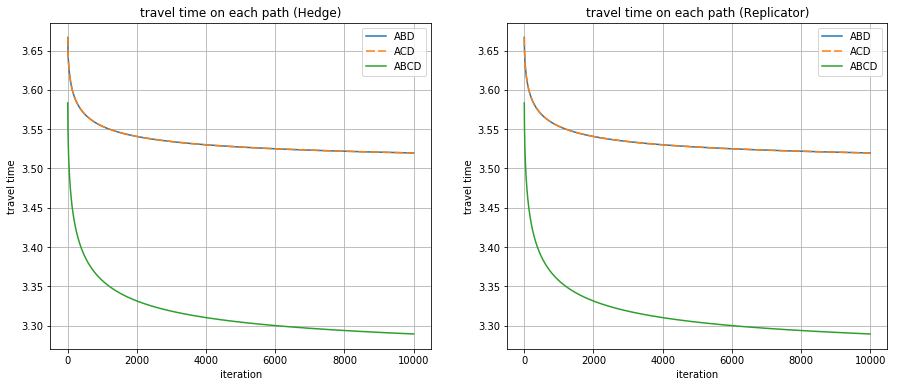

In [88]:
plt.figure(figsize=(15,6))
plt.subplot(121)
time = range(T)
plt.plot(time, ttravel_Hedge_lambda[:,0], label='ABD')
plt.plot(time, ttravel_Hedge_lambda[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Hedge_lambda[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Hedge)')
plt.grid()
plt.legend()

plt.subplot(122)

time = range(T)
plt.plot(time, ttravel_Replicator_lambda[:,0], label='ABD')
plt.plot(time, ttravel_Replicator_lambda[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, ttravel_Replicator_lambda[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Replicator)')
plt.grid()
plt.legend()
plt.show()

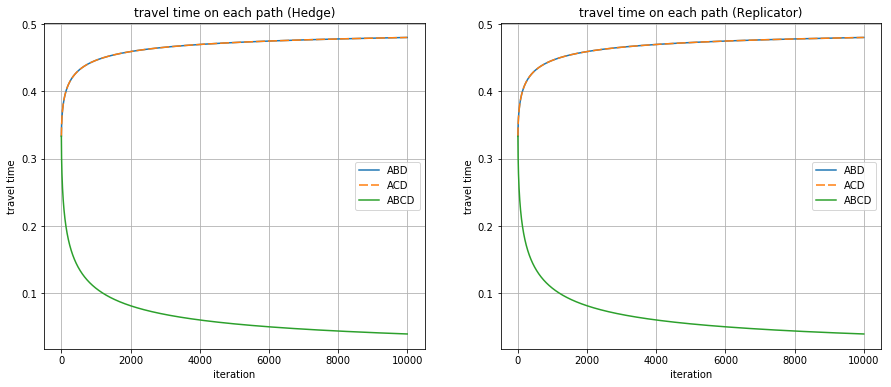

In [89]:
plt.figure(figsize=(15,6))
plt.subplot(121)
time = range(T+1)
plt.plot(time, f_Hedge_lambda[:,0], label='ABD')
plt.plot(time, f_Hedge_lambda[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, f_Hedge_lambda[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Hedge)')
plt.grid()
plt.legend()

plt.subplot(122)

time = range(T+1)
plt.plot(time, f_Replicator_lambda[:,0], label='ABD')
plt.plot(time, f_Replicator_lambda[:,1], dashes=[6, 2], label='ACD')
plt.plot(time, f_Replicator_lambda[:,2], label='ABCD')
plt.xlabel('iteration')
plt.ylabel('travel time')
plt.title('travel time on each path (Replicator)')
plt.grid()
plt.legend()
plt.show()